# Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
eval_df = pd.read_csv("tribunnews_politik_full.csv")
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    199 non-null    object
 1   url      199 non-null    object
 2   content  199 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [3]:
testing = eval_df['content']
testing.head()

0    TRIBUNNEWS.COM, JAKARTA - Istilah tebar pesona...
1    TRIBUNNEWS.COM, AMBON - Ketua Harian Partai So...
2    TRIBUNNEWS.COM, JAKARTA - Nahdlatul Ulama (NU)...
3    TRIBUNNEWS.COM, SURABAYA - Ketua DPD PDI Perju...
4    TRIBUNNEWS.COM, BANDUNG - Ketua DPW PSI Jawa B...
Name: content, dtype: object

Memeriksa missing value pada dataset.

In [4]:
print(f"\nMissing Values:\n{eval_df.isnull().sum()}")


Missing Values:
title      0
url        0
content    0
dtype: int64


Memeriksa baris data yang duplikat.

In [5]:
print(f"\nJumlah baris duplikat: {eval_df.duplicated().sum()}")


Jumlah baris duplikat: 0


Memeriksa panjang teks

In [6]:
eval_df['text_length'] = eval_df['content'].apply(lambda x: len(x.split()))
print(f"\nStatistik Deskriptif Panjang Teks:\n{eval_df['text_length'].describe()}")


Statistik Deskriptif Panjang Teks:
count    199.000000
mean     286.281407
std       87.245741
min       84.000000
25%      223.500000
50%      280.000000
75%      336.000000
max      679.000000
Name: text_length, dtype: float64


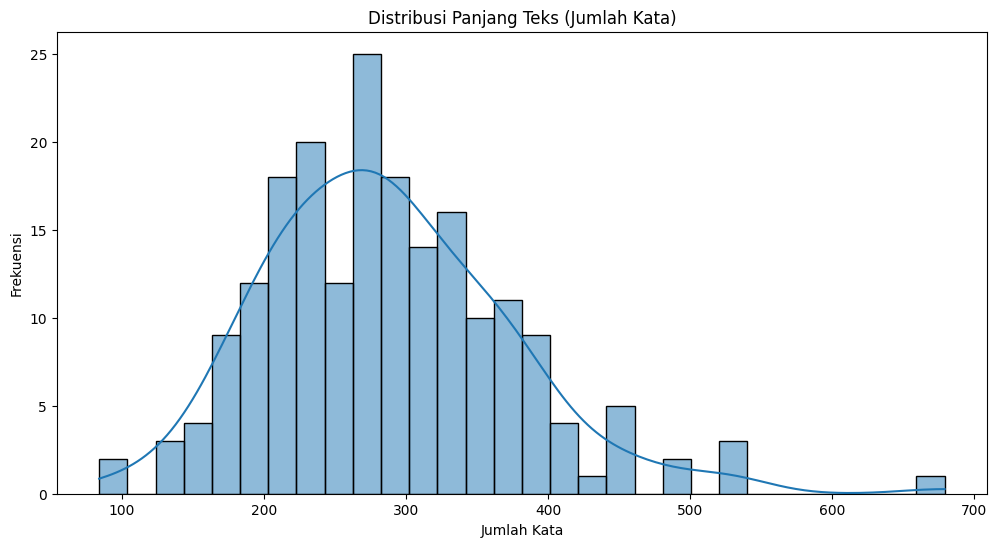

In [7]:
eval_df['text_length'].tolist()
plt.figure(figsize=(12, 6))
sns.histplot(eval_df['text_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Teks (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

Membuat wordcloud untuk melihat kata apa yang sering muncul di berita non-hoax dan berita hoax.

In [8]:
# stop words bahasa inggris
stop_words = set(stopwords.words('indonesian'))
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

C:\Users\user\AppData\Local\Temp\ipykernel_24236\2064961007.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='cividis')


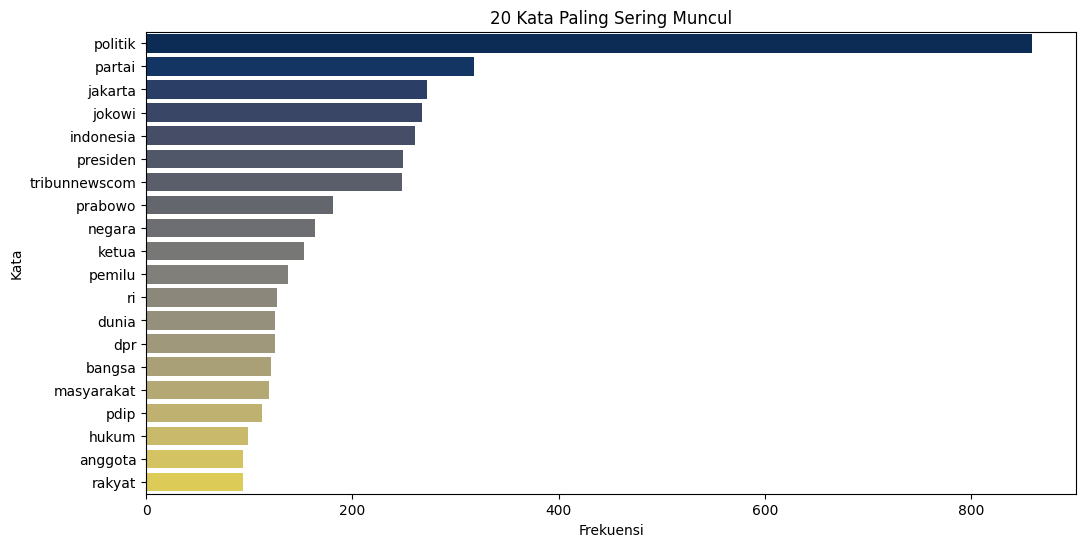

In [9]:
def clean_for_frequency(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())
    text = remove_stopwords(text)
    return text

all_words = ' '.join(eval_df['content'].apply(clean_for_frequency)).split()
word_counts = Counter(all_words)

# Kata-kata yang paling umum (Top 20)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='cividis')
plt.title('20 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [10]:
def word_cloud_plot(data, title):
    word_cloud_text = ' '.join(data)
    wordcloud = WordCloud(
        width=800,
        height=400,
        max_words=200,
        background_color='white'
    ).generate(word_cloud_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

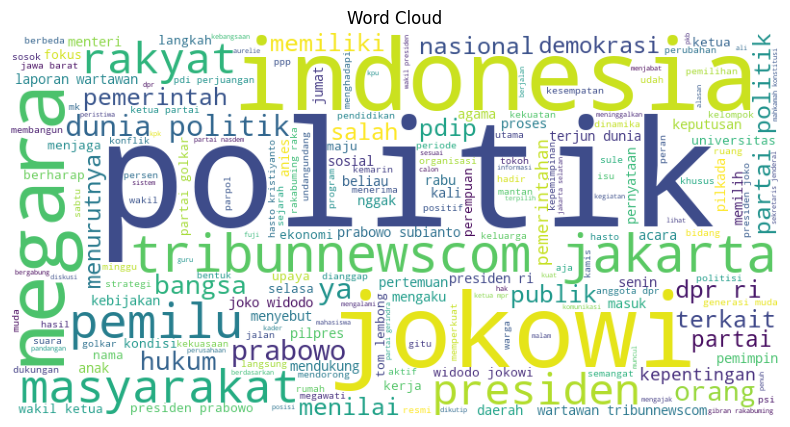

In [11]:
x = eval_df['content'].apply(clean_for_frequency)
word_cloud_plot(x, 'Word Cloud')

In [12]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained("indobert_hoax_detector_best")

In [13]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print(f"Training using: {device}")
else:
    device = torch.device("cpu")
    print(f"Training using: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Training using: cuda


In [14]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [15]:
test_dataset = TextDataset(
    texts=eval_df['content'].tolist(),
    labels=eval_df['content'].tolist(),
    tokenizer=tokenizer
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)


In [16]:
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }


In [17]:
testing_dataset = InferenceDataset(testing, tokenizer)

loader = DataLoader(testing_dataset, batch_size=16, shuffle=False)

preds = []
probs = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

        predictions = torch.argmax(probabilities, dim=1)

        preds.extend(predictions.cpu().numpy())
        probs.extend(probabilities.max(dim=1).values.cpu().numpy())


In [18]:
print("Jumlah data :", len(testing))
print("Jumlah prediksi :", len(preds))


Jumlah data : 199
Jumlah prediksi : 199


In [19]:
eval_df['pred_label'] = preds
eval_df['confidence'] = probs

eval_df['pred_text'] = eval_df['pred_label'].map({
    0: 'VALID',
    1: 'HOAX'
})


In [20]:
eval_df.head()

,title,url,content,text_length,pred_label,confidence,pred_text
0,"Tebar Pesona di Tengah Banjir, Masih Efektifka...",https://www.tribunnews.com/nasional/7763757/te...,"TRIBUNNEWS.COM, JAKARTA - Istilah tebar pesona...",275,1,0.740199,HOAX
1,PSI Puji Prabowo Akui Keberhasilan Jokowi: Pad...,https://www.tribunnews.com/nasional/7760973/ps...,"TRIBUNNEWS.COM, AMBON - Ketua Harian Partai So...",329,1,0.738261,HOAX
2,Nahdlatul Ulama Diharapkan Tetap Menjadi Rumah...,https://www.tribunnews.com/nasional/7759053/na...,"TRIBUNNEWS.COM, JAKARTA - Nahdlatul Ulama (NU)...",304,0,0.754962,VALID
3,Said Abdullah Sebut Regenerasi Pemilih Muda Ja...,https://www.tribunnews.com/nasional/7758786/sa...,"TRIBUNNEWS.COM, SURABAYA - Ketua DPD PDI Perju...",452,1,0.884087,HOAX
4,Ketua PSI Jabar: Bakal Ada Badai Politik Usai ...,https://www.tribunnews.com/nasional/7755070/ke...,"TRIBUNNEWS.COM, BANDUNG - Ketua DPW PSI Jawa B...",307,1,0.973804,HOAX


In [21]:
testing_label = eval_df['pred_text'].value_counts()
print(f"Distribusi kelas: {testing_label}")

Distribusi kelas: pred_text
HOAX     110
VALID     89
Name: count, dtype: int64
